In [13]:
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def brownian_motion(df, u, sigma):  
    dt = 1/360
    new_price = df.loc[df.index[-1]][0]*(1+u*dt + sigma * np.random.normal(0, 1) * np.sqrt(dt))
    df.loc[df.index[-1]+1] = new_price

def create_orders(market_price,buy=True):
    if buy:
        buy_orders_price = [market_price*(1-i/1500) for i in range(3)]
        buy_orders_size = [rd.randint(1, i) for i in np.linspace(10,50,3)]
        #buy_orders_size = [i for i in [10,20,30]]

        return [list(i) for i in zip(buy_orders_price, buy_orders_size)]
    else:
        sell_orders_price = [market_price*(1+i/1500) for i in range(3)]
        sell_orders_size = [rd.randint(1, i) for i in np.linspace(10,50,3)]
        #sell_orders_size = [i for i in [10,20,30]]
        return [list(i) for i in zip(sell_orders_price,sell_orders_size)]
        
trade_n = 0
def match_orders(i):
    global order_book_b, order_book_s,trades, trade_n
    while max(order_book_b['Price']) >= min(order_book_s['Price']):
        trade_n += 1 
        if order_book_b['Price'][0] >= order_book_s['Price'][0]:
            price = order_book_b['Price'][0]
            size = min(order_book_b['Size'][0], order_book_s['Size'][0])
            trades = trades.append(pd.DataFrame({'Price':price, 'Size':size, 'MP':i}, index=[trade_n]))

            order_book_b.loc[0,'Size'] -= size 
            order_book_s.loc[0,'Size'] -= size 
            
            if order_book_b.loc[0,'Size'] == 0:
                order_book_b = order_book_b.drop(0).reset_index(drop=True)
                
            if order_book_s.loc[0,'Size'] == 0:
                order_book_s = order_book_s.drop(0).reset_index(drop=True)

def match_orders_2(i):
    global order_book_b, order_book_s,trades, trade_n
    while min(order_book_s['Price']) <= max(order_book_b['Price']):
        trade_n += 1 
        if order_book_b['Price'][0] >= order_book_s['Price'][0]:
            price = order_book_s['Price'][0]
            size = min(order_book_b['Size'][0], order_book_s['Size'][0])
            trades = trades.append(pd.DataFrame({'Price':price, 'Size':size, 'MP':i}, index=[trade_n]))

            order_book_b.loc[0,'Size'] -= size 
            order_book_s.loc[0,'Size'] -= size 
            
            if order_book_b.loc[0,'Size'] == 0:
                order_book_b = order_book_b.drop(0).reset_index(drop=True)
                
            if order_book_s.loc[0,'Size'] == 0:
                order_book_s = order_book_s.drop(0).reset_index(drop=True)

def match_orders_3(i):
    global order_book_b, order_book_s,trades, trade_n
    while min(order_book_s['Price']) <= max(order_book_b['Price']):
        trade_n += 1 
        if order_book_b['Price'][0] >= order_book_s['Price'][0]:
            price = (order_book_s['Price'][0]+order_book_b['Price'][0])/2
            size = min(order_book_b['Size'][0], order_book_s['Size'][0])
            trades = trades.append(pd.DataFrame({'Price':price, 'Size':size, 'MP':i}, index=[trade_n]))

            order_book_b.loc[0,'Size'] -= size 
            order_book_s.loc[0,'Size'] -= size 
            
            if order_book_b.loc[0,'Size'] == 0:
                order_book_b = order_book_b.drop(0).reset_index(drop=True)
                
            if order_book_s.loc[0,'Size'] == 0:
                order_book_s = order_book_s.drop(0).reset_index(drop=True)

In [11]:
spreads = []
for i in range(200):
    price_series = pd.DataFrame(100,columns=['price'], index=[0])
    for i in range(30):
        brownian_motion(price_series, 0.1, 0.1)
        price_series['Ema-5'] = price_series.price.ewm(span=5).mean()
        price_series['Ema-20'] = price_series.price.ewm(span=20).mean()

    order_book_b = pd.DataFrame(create_orders(price_series.price[0]), columns=['Price', 'Size']).sort_values(by=['Price'], ascending=False).reset_index(drop=True)
    order_book_s = pd.DataFrame(create_orders(price_series.price[0],False), columns=['Price', 'Size']).sort_values(by=['Price']).reset_index(drop=True)

    trades = pd.DataFrame(columns=['Price','Size', 'MP'])

    for i in price_series.price:
        
        new_buy_orders=create_orders(i, True)
        for order in range(3):
            order_book_b.loc[len(order_book_b)+i] = new_buy_orders[order]
        order_book_b = order_book_b.sort_values(by=['Price'], ascending=False).reset_index(drop=True)

        new_sell_orders=create_orders(i,False)
        for order in range(3):
            order_book_s.loc[len(order_book_s)+i] = new_sell_orders[order]
        order_book_s = order_book_s.sort_values(by=['Price']).reset_index(drop=True)

        #order_book_b[(order_book_b.Price>i*0.95) & (order_book_b.Price<i*1.05)]
        #order_book_s[(order_book_s.Price>i*0.95) & (order_book_s.Price<i*1.05)]

        match_orders_3(i)
    spreads.append(((trades['Price']/trades['MP'])-1).mean())

Text(0.5, 1.0, 'Average spread: %-0.049626159250050345')

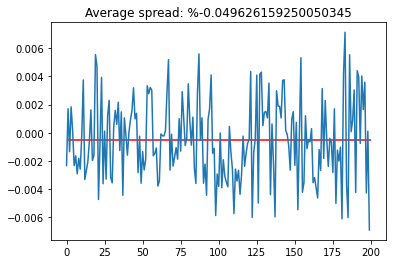

In [15]:
# When matched order price is average, no threshold
plt.plot(spreads)
average = sum(spreads)/len(spreads)
plt.hlines(average, xmin=0, xmax=200, color='red')
plt.title(f'Average spread: %{average*100}')

<AxesSubplot:>

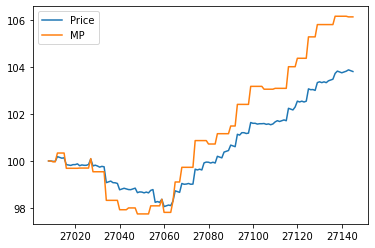

In [16]:
trades[['Price', 'MP']].plot()